# Temporal Difference Learning

Temporal difference (TD) learning is a **key method** for RL. 

In comparison to MC methods, the update for any estimation is calculated at every time step and does not have to wait for the episode to finish.

We will look at the prediction problem for the state-value function first and then go on to the control problem with SARSA and Q-learning, which will be implemented with the `Agent` interface from the last exercise.

In [1]:
# Import necessary files
import numpy as np
import matplotlib.pyplot as plt

# progress bar, see https://github.com/tqdm/tqdm
import tqdm

import gymnasium as gym

import sys

sys.path.append('.')
from mdp import RState, MDPGridworld, WalledGridworld, SlipperyGridworld
from mdp_env import MDPEnv, Agent
from util import max_arg_with_ties, plot_policy_values


We will use the same two gridworlds as in the last exercises.

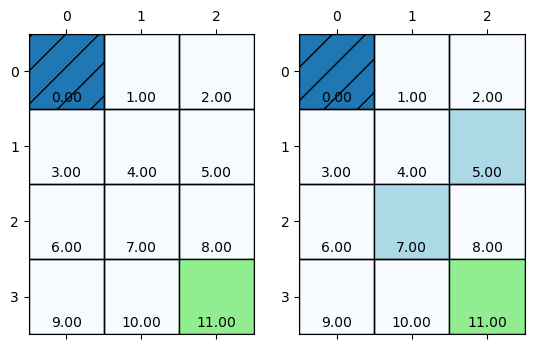

In [2]:
# Normal gridworld
gw = MDPGridworld(height=4, width=3)
gw.state(0, 0).is_terminal = True
gw.state(3,2).color = 'lightgreen'

# Slippery gridworld
gws = SlipperyGridworld(4, 3)
gws.state(0,0).is_terminal = True
gws.state(3,2).color = 'lightgreen'

gws.add_wall(0,0,1,0)
gws.add_slippery_patch(1,2, 0.5)
gws.add_slippery_patch(2,1, 0.5)

# Plot the gridworlds and their ids (we will use id 11 as start, merked greed)
fig, axs = plt.subplots(ncols=2)
gw.render(gw.all_state_ids(), axs[0])
gws.render(gws.all_state_ids(), axs[1])

We will also use the same env as in the last exercise. It is located and imported from a seperate file.

## TD(0) prediction

In the first exercise we want to implement the TD(0) algorithm to estimate the state-value function for a given policy. We will later use the action-values for control, but the state-values are slightly easier to calculate, so we will start with them.

You should implement a constant step_size update, where the step_size is given.


In [26]:
def td_prediction(env: gym.Env, nr_states: int, policy: np.ndarray, gamma: float, step_size: float, num_repetitions: int) \
        -> np.ndarray:
    """
    Estimate the value function for the environment for the given policy

    Args:
        env: the environment
        nr_states: the number of states in the MDP of the environment
        policy: the policy to evaluate
        gamma:
        step_size: the step size for the value estimation update
        num_repetitions: number of episodes for the prediction
    """
    # initialize v
    v = np.zeros(nr_states)
    for _ in range(num_repetitions):

        # initialize episode
        state_id, _ = env.reset()
        # take first action
        # YOUR CODE HERE
        action = np.random.choice(policy.shape[1], p=policy[state_id,:])

        done = False
        while True:
            # take action and update v
            obs, reward, done, _, _ = env.step(action)
            v[state_id] = v[state_id] + step_size * ( reward + gamma * v[obs] - v[state_id])
            if done:
                break
            action = np.random.choice(policy.shape[1], p=policy[state_id,:])
            state_id = obs
    return v

In [27]:
env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)
p = np.zeros((len(gw.states), gw.NR_ACTIONS))
p.fill(1.0 / gw.NR_ACTIONS)

np.random.seed(1)
v = td_prediction(env, len(gw.states), p, 1.0, 0.05, 1000)

np.random.seed(1)
v2 = td_prediction(env, len(gw.states), p, 0.9, 0.05, 1000)

np.testing.assert_allclose(v, [  0., -16.14, -25.99,  -18.69,  -24.79, -29.25, -29.04, -32.23, -33.31, -34.83, -35.96, -37.11], atol=0.1)
np.testing.assert_allclose(v2, [ 0., -4.83, -7.19, -5.25, -6.78, -7.73, -7.42, -8.07, -8.31, -8.42, -8.61, -8.79,], atol=0.1)


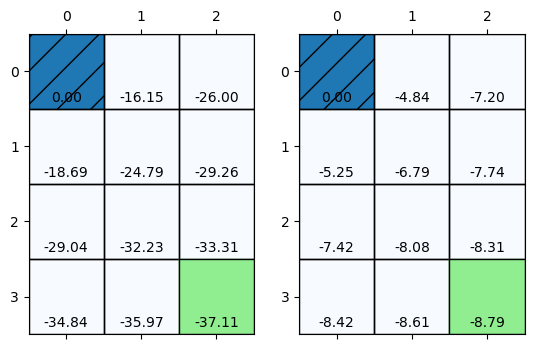

In [28]:
# Let us also look at the results
fig, axs = plt.subplots(ncols=2)
gw.render(v, axs[0])
gw.render(v2, axs[1])


## TD(0) on policy control: SARSA

SARSA is the on-policy control algorithms for TD(0) with one step update and immediately using the new values for the policy (it is a bit similar to value iteration in Dynamic Programming). 

The policy must be epsilon-soft, so we will use an epsilon-greedy policy. In order to be able to calculate these policies we now need to estimate the action-value function.

In [55]:
class SarsaAgent(Agent):
    """
    Sarsa Agent
    """

    def __init__(self, action_space, state_space, gamma: float, step_size: float, epsilon: float):
        """
        Initialize Sarsa

        Args:
            action_space: the action space
            state_space: the state space
            gamma: the discount factor
            step_size: the step size for the update
            epsilon: the epsilon for the epsilon greedy policy
        """
        super().__init__(action_space, state_space)
        self._env = env
        self._epsilon = epsilon
        self._gamma = gamma
        self._step_size = step_size

        # We want to estimate the state-action value function
        self._q = np.zeros((state_space.n, self._action_space.n))

        # we need to remember the last state and action
        self._last_state_id = None
        self._last_action = None

    @property
    def q(self):
        return self._q

    def reset(self):
        """
        Reset the learning of the agent to an initial condition, so it can be used in a new env.
        """
        self._q.fill(0.0)

    def get_eps_greedy_action(self, state) -> int:
        """
        Helper function to get the epsilon greedy action from the indicated state as we do
        not need to specify a policy explicitely. Use max_arg_with_ties for the greedy case.

        Return the taken action.
        """
        # YOUR CODE HERE
        if np.random.rand() > self._epsilon:
            # Greedy
            action = max_arg_with_ties(self._q[state, :])
        else:
            # Exploration
            action = np.random.choice(self._action_space.n)
        return action

    def step_first(self, observation) -> int:
        """
        First step after reset or initialization with the first observation from the environment. In our
        gridwold environment the observation is the current state.
        """
        # you will need to:
        # - save the observation (the state)
        # - determine the next action, save and return it

        # YOUR CODE HERE
        self._last_state_id = observation
        action = self.get_eps_greedy_action(observation)
        self._last_action = action
        return action
        
    def step(self, observation, reward, done) -> int or None:
        """
        Step in the environment. The reward is the returned reward from the last action and the
        observation contains the state after performing the last action.
        Args:
            observation: the observation from the environment (here the state_id)
            reward: the reward from the last action
            done: true if the episode is finished as a terminal state has been reached
        Returns:
            the action to take next or None if the episode is finished
        """
        if not done:
            # During the episodes you will need to
            # - determine the next action
            # - update the action-state estimates
            # - save the state and action
            # - return the action

            # to make the calculation more clear
            state_id = observation

            # YOUR CODE HERE
            action = self.get_eps_greedy_action(observation)
            last_state = self._last_state_id
            last_action = self._last_action
            self._q[last_state, last_action] = self._q[last_state, last_action] + self._step_size * (reward + self._gamma * self._q[observation, action] - self._q[last_state, last_action])
            self._last_state_id = observation
            self._last_action = action
            return action
            
        else:
            # episode is done, but we still need to calculate the last update,

            # all action values from the terminal state are considered zero
            # YOUR CODE HERE
            last_state = self._last_state_id
            last_action = self._last_action
            self._q[last_state, last_action] = self._q[last_state, last_action] + self._step_size * (reward - self._q[last_state, last_action])
            # we return None as there is no action from a terminal state
            return None

    def train(self, env, nr_episodes):
        for _ in range(nr_episodes):
            obs, _ = env.reset()
            a = self.step_first(obs)
            done = False
            while not done:
                obs, reward, done, _, _ = env.step(a)
                a = self.step(obs, reward, done)


In [56]:
env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)
agent = SarsaAgent(env.action_space, env.observation_space, gamma=1.0, step_size=0.05, epsilon=0.05)

agent.reset()
assert (agent.q == 0.0).all()

# simulate one step
a = agent.step_first(1)
assert a >= 0
assert a < 4

# simulate end of episode
a2 = agent.step(0, -1, True)
assert a2 is None
# this value was updated
assert agent.q[1, a] == -0.05

np.random.seed(1)
agent.train(env, 10000)

np.testing.assert_allclose([-2.03264807,-2.96864979,-3.1029341 ,-1.        ], agent.q[1,:], atol=1.0)
np.testing.assert_allclose([-5.3443384, -6.16508002, -6.22824094, -5.21986845], agent.q[11,:], atol=1.0)

# try with discount factor
agent2 = SarsaAgent(env.action_space, env.observation_space, gamma=0.9, step_size=0.05, epsilon=0.05)
agent2.train(env, 10000)
np.testing.assert_allclose([-1.90006585, -2.65332789, -2.51679344, -1. ], agent2.q[1,:], atol=1.0)

To evalulate the result we can plot the maximum value over the action in a state and the mean value over the actions. 

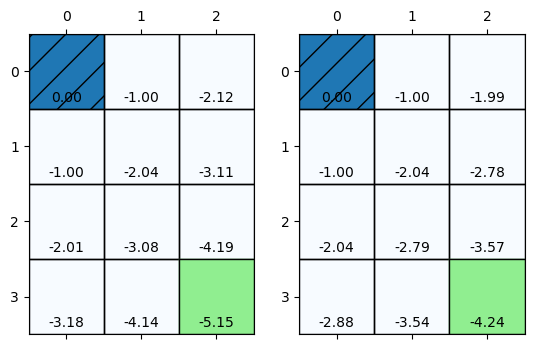

In [57]:
fig, axs = plt.subplots(ncols=2)
gw.render(agent.q.max(axis=1),axs[0])
gw.render(agent2.q.max(axis=1),axs[1])

We can see that even with discount factor 1.0, we do not get the optimal value for all states, for example the state (0,2) has the value -2.03, but -2 would be the value for the optimal policy. Why did we not get this? (Answer will be discussed in the lecture :-) )

In [58]:
def greedy_from_action_values(q) -> np.ndarray:
    """
    Calculate a greedy policy from the action values.
    """
    p = np.zeros(q.shape)
    best_action = q.argmax(axis=1)
    for a in range(q.shape[1]):
        p[:, a] = (best_action == a).astype(float)
    return p

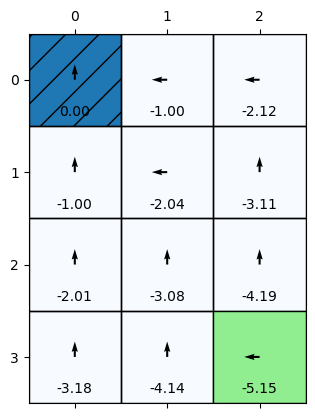

In [59]:
p_greedy = greedy_from_action_values(agent.q)
plot_policy_values(p_greedy, agent.q.max(axis=1), gw)

### Results of Sarsa

We have to be careful with analyzing the plot, the printed value function corresponds to the greedy action which is shown in the array. But the state reached by that action might not be the one that displays the highest value. For example the q function at (1,2) is

In [60]:
print(agent.q[7])

[-3.08152805 -4.95770316 -5.19640997 -3.1742092 ]


## Q Learning

The next agent that we want to implement is a q-learning agent. In comparison to SARSA is this an offline algorithms which will use the best of the available actions for the update.


In [71]:
class QLearningAgent(Agent):
    """
    Q-Learning Agent
    """

    def __init__(self, action_space, state_space, gamma: float, step_size: float, epsilon: float):
        """

        Args:
            action_space: the action space
            state_space: the state space
            gamma: the discount factor
            step_size: the step size for the update
            epsilon: the epsilon for the epsilon greedy policy
        """
        super().__init__(action_space, state_space)
        self._env = env
        self._epsilon = epsilon
        self._gamma = gamma
        self._step_size = step_size

        # We want to estimate the state-action value function
        self._q = np.zeros((state_space.n, self._action_space.n))

        # we need to remember the last state and action
        self._last_state_id = None
        self._last_action = None

    @property
    def q(self):
        return self._q

    def reset(self):
        """
        Reset the learning of the agent to an initial condition, so it can be used in a new env.
        """
        self._q.fill(0.0)

    def get_eps_greedy_action(self, state):
        """
        Helper function to get the epsilon greedy action from the indicated state
        """

        # this is the same as in SARSA

        # YOUR CODE HERE
        if np.random.rand() > self._epsilon:
            # Greedy
            action = max_arg_with_ties(self._q[state, :])
        else:
            # Exploration
            action = np.random.choice(self._action_space.n)
        return action

    def step_first(self, observation) -> int:
        """
        First step after reset or initialization with the first observation from the environment.
        """
        # as there is no update, this is also the same as in SARSA
        # YOUR CODE HERE
        self._last_state_id = observation
        action = self.get_eps_greedy_action(observation)
        self._last_action = action
        return action
    def step(self, observation, reward, done) -> int or None:
        """
        Step in the environment. The reward is the returned reward from the last action.
        """

        if not done:
            # to make the calculation more clear
            state_id = observation

            # you will have to do the same steps as in SARSA, but the update will be different
            # YOUR CODE HERE
            
            last_state = self._last_state_id
            last_action = self._last_action
            action = self.get_eps_greedy_action(state_id)
            max_action = max_arg_with_ties(self._q[observation])
            self._q[last_state, last_action] = self._q[last_state, last_action] + self._step_size * (reward + self._gamma * self._q[observation, max_action] - self._q[last_state, last_action])
            self._last_state_id = observation
            self._last_action = action
            return action
        else:
            # episode done, but we still need to calculate the last update, all action values
            # from the terminal state are considered zero
            # YOUR CODE HERE
            last_state = self._last_state_id
            last_action = self._last_action
            self._q[last_state, last_action] = self._q[last_state, last_action] + self._step_size * (reward - self._q[last_state, last_action])
            return None

    def train(self, env, nr_episodes):
        for e in range(nr_episodes):
            obs, _ = env.reset()
            a = self.step_first(obs)
            done = False
            while not done:
                obs, reward, done, _, _ = env.step(a)
                a = self.step(obs, reward, done)



In [72]:
env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)
agent = QLearningAgent(env.action_space, env.observation_space, gamma=1.0, step_size=0.05, epsilon=0.05)

agent.reset()
assert (agent.q == 0.0).all()

# simulate one step
a = agent.step_first(1)
assert a >= 0
assert a < 4

# simulate end of episode
a2 = agent.step(0, -1, True)
assert a2 is None
# this value was updated
assert agent.q[1, a] == -0.05

agent.train(env, 10000)

agent2 = QLearningAgent(env.action_space, env.observation_space, gamma=0.9, step_size=0.05, epsilon=0.05)
agent2.train(env, 10000)

np.testing.assert_allclose([-1.87121275, -2.68771325, -2.84147629, -1.        ], agent.q[1,:], atol=0.3)
np.testing.assert_allclose([-1.80552557, -2.53051759, -2.48628421, -1.        ], agent2.q[1,:], atol=0.3)

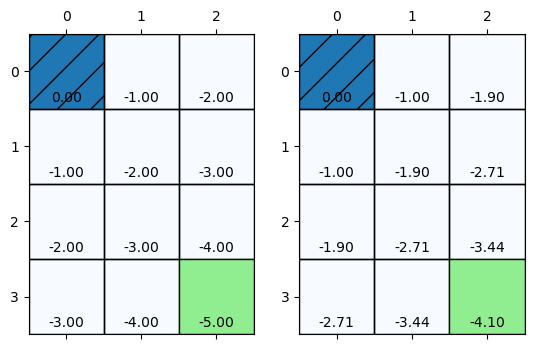

In [73]:
fig, axs = plt.subplots(ncols=2)
gw.render(agent.q.max(axis=1),axs[0])
gw.render(agent2.q.max(axis=1),axs[1])

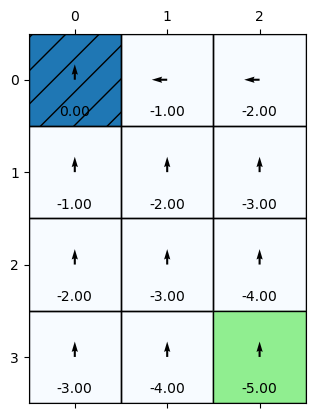

In [74]:
# Let us also plot the policy
p_greedy = greedy_from_action_values(agent.q)
plot_policy_values(p_greedy, agent.q.max(axis=1), gw)

### Sleepery Gridworld with SARSA and Q-Learning

As a last example, let us compare SARSA and Q-Learning on the slippery gridworld.

In [75]:
env = MDPEnv(gws.states, gws.NR_ACTIONS, 11)
agent_s = SarsaAgent(env.action_space, env.observation_space, gamma=1.0, step_size=0.05, epsilon=0.05)
agent_q = QLearningAgent(env.action_space, env.observation_space, gamma=1.0, step_size=0.05, epsilon=0.05)

np.random.seed(1)
agent_s.train(env, 20000)
agent_q.train(env, 20000)

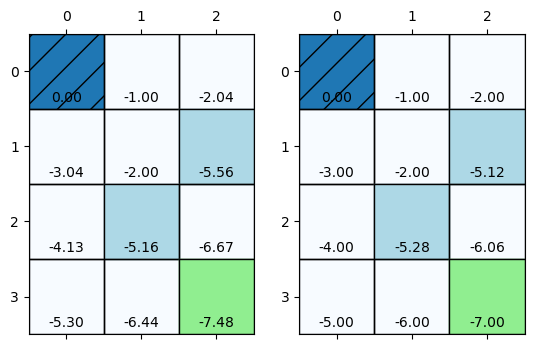

In [76]:
fig, axs = plt.subplots(ncols=2)
gws.render(agent_s.q.max(axis=1),axs[0])
gws.render(agent_q.q.max(axis=1),axs[1])

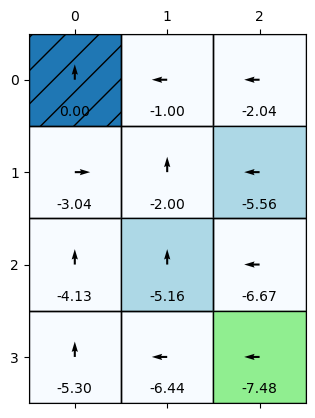

In [77]:
p_greedy_s = greedy_from_action_values(agent_s.q)
plot_policy_values(p_greedy_s, agent_s.q.max(axis=1), gws)

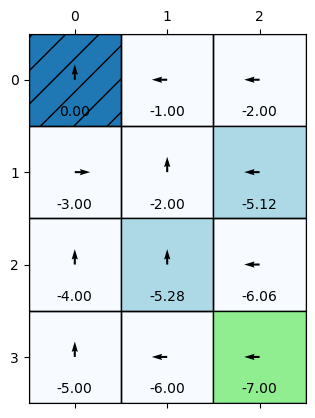

In [78]:
p_greedy_q = greedy_from_action_values(agent_q.q)
plot_policy_values(p_greedy_q, agent_q.q.max(axis=1), gws)

Depending on the probability to fall in the slippery patches the algorithms will choose to go through the patches or avoid them.

This is all for this exercise